In [1]:
import torch

Load the data

In [2]:
import torchvision
from torchvision import transforms, datasets

batch_size = 16

image_width = 32
image_height = 32
num_channels = 3

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Show some of the images and labels of the loaded image

torch.Size([16, 3, 32, 32])


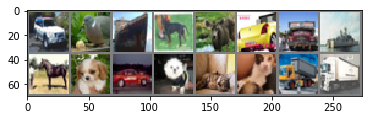

  car  bird  ship   dog  deer   car truck  ship horse   dog   car   dog   cat   cat truck truck


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = iter(trainloader).next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
from torch import nn, optim
from collections import OrderedDict

dropout_prob = 0.4
learning_rate = 0.001
input_size = image_width * image_height * num_channels
hidden_size = 512
output_size = 10
print(model)
model = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, hidden_size)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(dropout_prob)),
                                        ('fc2', nn.Linear(hidden_size, output_size)),
                                        ('output', nn.LogSoftmax(dim=1))]))


Set loss function

In [8]:
criterion = nn.NLLLoss()

Set optimizer

In [9]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Use gpu if available

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (output): LogSoftmax()
)

Start training

In [11]:
epochs = 3
print_every = 1000
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.view(batch_size, input_size)

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % print_every == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / print_every))
            running_loss = 0.0

print('Finished Training')

[1,     0] loss: 0.002
[1,  1000] loss: 2.083
[1,  2000] loss: 1.984
[1,  3000] loss: 1.974
[2,     0] loss: 0.002
[2,  1000] loss: 1.942
[2,  2000] loss: 1.934
[2,  3000] loss: 1.919
[3,     0] loss: 0.002
[3,  1000] loss: 1.909
[3,  2000] loss: 1.917
[3,  3000] loss: 1.915
Finished Training


Save the trained model

In [12]:
PATH = './checkpoint.pth'
torch.save(model.state_dict(), PATH)

Test the trained model.
First load a batch and see the actual values. 
Then predict using our model and compare

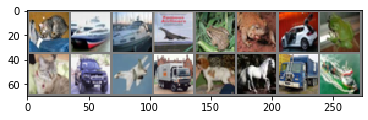

Real labels:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


In [13]:
images, labels = iter(testloader).next()

imshow(torchvision.utils.make_grid(images))
print('Real labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Load the saved model

In [14]:
saved_model = nn.Sequential(OrderedDict([('fc1', nn.Linear(input_size, hidden_size)),
                                        ('relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(dropout_prob)),
                                        ('fc2', nn.Linear(hidden_size, output_size)),
                                        ('output', nn.LogSoftmax(dim=1))]))
saved_model.load_state_dict(torch.load(PATH))

RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "fc3.weight", "fc3.bias". 
	size mismatch for fc2.weight: copying a param with shape torch.Size([64, 512]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([10]).

Predict using our model

In [15]:
images = images.view(batch_size, input_size)
_, predicted = torch.max(torch.exp(model.forward(images)), dim=1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    dog truck  ship plane horse   cat   cat   dog   dog   car plane truck  deer   dog   car  ship


Check the accuracy on the test data

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(batch_size, input_size)
        images = outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 30 %


### References

- [Learning Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

- [Training a Classifier - Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)